# 로지스틱 회귀 연습문제

In [1]:
from pandas import read_excel, DataFrame, merge, get_dummies
import pandas as pd
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import sys, os
from patsy import dmatrix

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit, scalling

## 문제1

피마 인디언 당뇨병 발병여부를 예측할 수 있는 분석 모델을 구현하기 위해 아래와 같은 항목들을 조사하였다. 분석하라.

### 데이터 가져오기

In [2]:
df = read_excel("https://data.hossam.kr/E05/indian_diabetes.xlsx")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 정규성을 만족한다는 전제

### 데이터 전처리 없이 분석 수행

In [3]:
# 당뇨여부(outcome) = 종속변수 / 그 외 = 독립변수
model = logit('Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age', data=df)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.2718
Time:                        10:56:45   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.4047      0.717    -11.728      0.000      -9.809

In [4]:
# 로지스틱 회귀의 설명력 - 의사결정계수
fit.prsquared

0.27180966859224576

In [5]:
# 예측결과를 데이터프레임에 추가
df['예측값'] = fit.predict(df.drop('Outcome', axis=1))
df['예측결과'] = df['예측값'] > 0.5
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,예측값,예측결과
0,6,148,72,35,0,33.6,0.627,50,1,0.721727,True
1,1,85,66,29,0,26.6,0.351,31,0,0.048642,False
2,8,183,64,0,0,23.3,0.672,32,1,0.796702,True
3,1,89,66,23,94,28.1,0.167,21,0,0.041625,False
4,0,137,40,35,168,43.1,2.288,33,1,0.902184,True
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0.317115,False
764,2,122,70,27,0,36.8,0.340,27,0,0.318969,False
765,5,121,72,23,112,26.2,0.245,30,0,0.170416,False
766,1,126,60,0,0,30.1,0.349,47,1,0.284976,False


### 혼동행렬 구하기

In [6]:
cm = confusion_matrix(df['Outcome'], df['예측결과'])

tn, fp, fn, tp = cm.ravel()

# print(tn, fp, fn, tp)

cmdf = DataFrame([[tn,tp],[fn,fp]], index=['True', 'False'], columns=['Negative','Positive'])
cmdf

,Negative,Positive
True,445,156
False,112,55


### ROC Curve 시각화

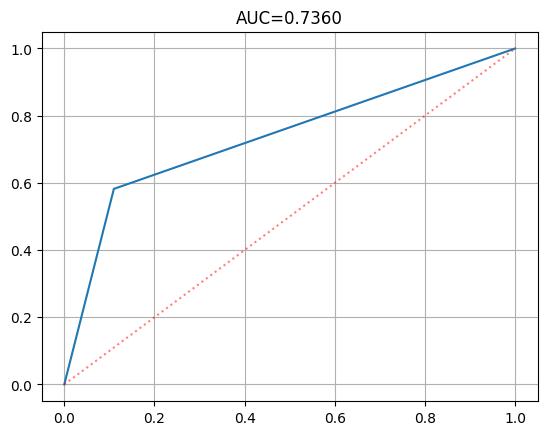

In [7]:
ras = roc_auc_score(df['Outcome'], df['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(df['Outcome'], df['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [8]:
# 정확도
acc = accuracy_score(df['Outcome'], df['예측결과'])

#정밀도
pre = precision_score(df['Outcome'], df['예측결과'])

#재현율
recall = recall_score(df['Outcome'], df['예측결과'])

#F1 score
f1 = f1_score(df['Outcome'], df['예측결과'])

#위양성율
fallout = fp / (fp+tn)

#특이성
spe = 1-fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)' : [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], 'f1_score':[f1], '위양성율':[fallout], '특이성':[spe] })

result_df.T

,0
설명력(Pseudo-Rsqe),0.271810
정확도(Accuracy),0.782552
정밀도(Precision),0.739336
"재현율(Recall, TPR)",0.582090
f1_score,0.651357
위양성율,0.110000
특이성,0.890000


### 오즈비 구하기

In [9]:
coef = fit.params
coef

Intercept                  -8.404696
Pregnancies                 0.123182
Glucose                     0.035164
BloodPressure              -0.013296
SkinThickness               0.000619
Insulin                    -0.001192
BMI                         0.089701
DiabetesPedigreeFunction    0.945180
Age                         0.014869
dtype: float64

### 오즈비 계산

In [10]:
odds_rate = np.exp(coef)
odds_rate

Intercept                   0.000224
Pregnancies                 1.131091
Glucose                     1.035789
BloodPressure               0.986792
SkinThickness               1.000619
Insulin                     0.998809
BMI                         1.093847
DiabetesPedigreeFunction    2.573276
Age                         1.014980
dtype: float64

### 표준화 

In [11]:
mdf = df.drop('Outcome', axis=1)
mdf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,예측값,예측결과
0,6,148,72,35,0,33.6,0.627,50,0.721727,True
1,1,85,66,29,0,26.6,0.351,31,0.048642,False
2,8,183,64,0,0,23.3,0.672,32,0.796702,True
3,1,89,66,23,94,28.1,0.167,21,0.041625,False
4,0,137,40,35,168,43.1,2.288,33,0.902184,True
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0.317115,False
764,2,122,70,27,0,36.8,0.340,27,0.318969,False
765,5,121,72,23,112,26.2,0.245,30,0.170416,False
766,1,126,60,0,0,30.1,0.349,47,0.284976,False


In [12]:
sdf = scalling(mdf.filter(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction' , 'Age']))
sdf 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732


In [13]:
sdf['Outcome'] = df['Outcome']
sdf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1
...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136,0
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023,0
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732,1


In [14]:
logit_result = my_logit(sdf, y='Outcome', x=['Pregnancies',	'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
print(logit_result.summary)

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.2718
Time:                        10:56:45   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8711      0.097     -8.986      0.000      -1.061

In [15]:
logit_result.model.fit().pred_table()

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6


array([[445.,  55.],
       [112., 156.]])

********

## 문제 2

다음의 데이터는 타이타닉 탑승객 명단 데이터이다. 적절한 데이터 전처리와 정제를 수행한 후 분석하라.

In [31]:
df2 = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [32]:
# 생존유무(Survived) = 종속변수 / 나머지 = 독립변수 (columns.difference.)

### 데이터 전처리 & 정제

In [33]:
df2['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [34]:
# 1) 이름, 티켓번호, 선실, passengerid 컬럼 삭제
df2.drop('Name', axis=1, inplace=True)
df2.drop('Ticket', axis=1, inplace=True)
df2.drop('Cabin', axis=1, inplace=True)
df2.drop('PassengerId', axis=1, inplace=True)

In [35]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [36]:
# 2) Sex 컬럼을 라벨링화
df2.replace({'Sex':'male'}, 0 ,inplace=True)
df2.replace({'Sex':'female'}, 1 ,inplace=True)
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S
887,1,1,1,19.0,0,0,30.0000,S
888,0,3,1,NaN,1,2,23.4500,S
889,1,1,0,26.0,0,0,30.0000,C


In [37]:
# 3) nan값 결측치 채우기
df2['Age'].fillna(df2['Age'].mean(), inplace=True)

In [38]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,S
1,1,1,1,38.000000,1,0,71.2833,C
2,1,3,1,26.000000,0,0,7.9250,S
3,1,1,1,35.000000,1,0,53.1000,S
4,0,3,0,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,S
887,1,1,1,19.000000,0,0,30.0000,S
888,0,3,1,29.699118,1,2,23.4500,S
889,1,1,0,26.000000,0,0,30.0000,C


In [40]:
# 4) 명목형 변수 확인 = pclass, sex, embarked
df3 = get_dummies(df2, columns=['Pclass','Sex','Embarked'], drop_first=True, dtype='int')
df3

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_1,Embarked_Q,Embarked_S
0,0,22.000000,1,0,7.2500,0,1,0,0,1
1,1,38.000000,1,0,71.2833,0,0,1,0,0
2,1,26.000000,0,0,7.9250,0,1,1,0,1
3,1,35.000000,1,0,53.1000,0,0,1,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,1,0,0,0,1
887,1,19.000000,0,0,30.0000,0,0,1,0,1
888,0,29.699118,1,2,23.4500,0,1,1,0,1
889,1,26.000000,0,0,30.0000,0,0,0,0,0


### 회귀분석

In [43]:
logit_result = my_logit(df2, y='Survived', x=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])
print(logit_result.summary)

Optimization terminated successfully.
         Current function value: 0.441051
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.3370
Time:                        11:08:37   Log-Likelihood:                -392.09
converged:                       True   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 3.680e-81
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.5665      0.518      4.958      0.000       1.552       3.581
Embarked[T.Q]    -0.

In [46]:
logit_result.cmdf

,Negative,Positive
True,474,238
False,104,75


In [45]:
logit_result.result_df.T

,0
설명력(Pseudo-Rsqe),0.337016
정확도(Accuracy),0.799102
정밀도(Precision),0.760383
"재현율(Recall, TPR)",0.695906
f1_score,0.726718
위양성율,0.136612
특이성,0.863388


### 가상의 데이터를 통한 생존확률 구하기